In [1]:
# this notebook is to train bot trading stocking with various signal features with reinforcement learning

# import helper functions on getting stock data
from getstock import get_stock_data_yf

# import Technical Analysis functions
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator

# import library for gym, stable-baselines3, A2C, and numpy
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

import numpy as np
from matplotlib import pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C



/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get stock data on Apple for the past 1 year with 5 days intervals
stock_data = get_stock_data_yf('AAPL', 1, '1d')

# show the first 5 rows of the stock data
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-28,149.820007,153.169998,149.720001,152.570007,151.719849,100077900
2021-10-29,147.220001,149.940002,146.410004,149.800003,148.965271,124953200
2021-11-01,148.990005,149.699997,147.800003,148.960007,148.129944,74588300
2021-11-02,148.660004,151.570007,148.649994,150.020004,149.184036,69122000
2021-11-03,150.389999,151.970001,149.820007,151.490005,150.645844,54511500


In [3]:
# initialize the technical indicators
sma = SMAIndicator(close=stock_data['Close'], window=12, fillna=True)
rsi = RSIIndicator(stock_data['Close'], window=14, fillna=True)
obv = OnBalanceVolumeIndicator(stock_data['Close'], stock_data['Volume'], fillna=True)

# add custom indicators to the stock data
stock_data['SMA'] = sma.sma_indicator()
stock_data['RSI'] = rsi.rsi()
stock_data['OBV'] = obv.on_balance_volume()

# show the last 15 rows of the stock data with the custom indicators
stock_data.tail(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2022-10-10,140.419998,141.889999,138.570007,140.419998,140.419998,74899000,145.364164,36.079104,-405814800
2022-10-11,139.899994,141.350006,138.220001,138.979996,138.979996,77033700,144.409997,34.627011,-482848500
2022-10-12,139.130005,140.360001,138.160004,138.339996,138.339996,70433700,143.374163,33.972574,-553282200
2022-10-13,134.990005,143.589996,134.369995,142.990005,142.990005,113224000,142.643331,42.478852,-440058200
2022-10-14,144.309998,144.520004,138.190002,138.380005,138.380005,88512300,141.688332,37.342545,-528570500
2022-10-17,141.070007,142.899994,140.270004,142.410004,142.410004,85250900,141.682499,43.746077,-443319600
2022-10-18,145.490005,146.699997,140.610001,143.750000,143.750000,99136600,142.144999,45.732052,-344183000
2022-10-19,141.690002,144.949997,141.500000,143.860001,143.860001,61758300,142.262499,45.900896,-282424700
2022-10-20,143.020004,145.889999,142.649994,143.389999,143.389999,64522000,142.036666,45.253038,-346946700


In [4]:
# helper function to add the custom indicators to the environment
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low','Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [5]:
# create the custom environment with signal features
class CustomStockEnv(StocksEnv):
    _process_data = add_signals

custenv = CustomStockEnv(df=stock_data, window_size=12, frame_bound=(12, 120))


In [6]:
# setup stable-baselines3 A2C model and train the model
env_maker = lambda: custenv
env = DummyVecEnv([env_maker])

model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 510      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.677   |
|    explained_variance | 0.253    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.203   |
|    value_loss         | 0.718    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 629      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.66    |
|    explained_variance | 0.0307   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 2.14     |
|    value_loss     

In [13]:
# Evaluate the trained model
testenv = CustomStockEnv(df=stock_data, window_size=12, frame_bound=(80, 300))
obs = testenv.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = testenv.step(action)
    if done:
        print("info:", info)
        break

info: {'total_reward': 31.230010986328125, 'total_profit': 0.8836522160125679, 'position': 1}


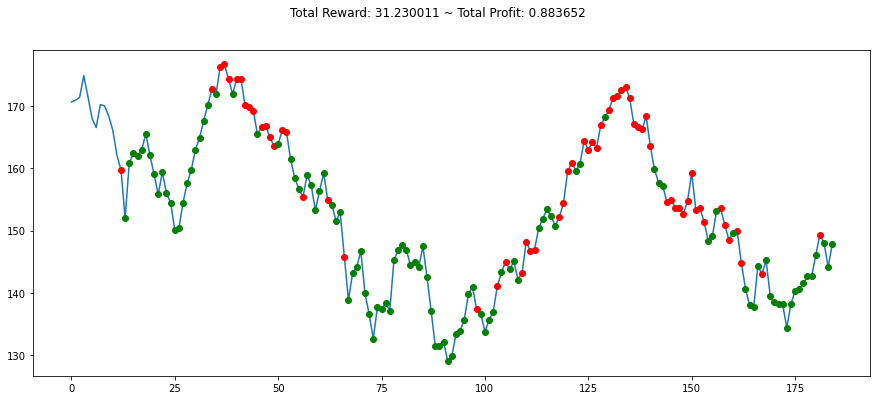

In [14]:
# plot the results
plt.figure(figsize=(15, 6))
plt.cla()
testenv.render_all()
plt.show()